# Projekt zaliczeniowy - Paweł Strenkowski

W niniejszym projekcie zostanie przeprowadzona analiza danych lotów lotniczych i model do predykcji opóżnień lotów. W projekcie została wykorzystana biblioteka dask

Import bibliotek

In [2]:
import pickle

import dask.array as da
import dask.dataframe as dd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.linear_model import BayesianRidge, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor


import warnings

warnings.filterwarnings("ignore")


Ładowanie danych

In [3]:
df = dd.read_csv('Combined_Flights_2019.csv').compute()
columns = df.columns
columns

Index(['FlightDate', 'Airline', 'Origin', 'Dest', 'Cancelled', 'Diverted',
       'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'DepDelay', 'ArrTime',
       'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime',
       'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek',
       'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners',
       'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline',
       'Flight_Number_Marketing_Airline', 'Operating_Airline',
       'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline',
       'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID',
       'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName',
       'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
       'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName',
       'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepDel15',
       'DepartureDelayGroups', 'DepTimeBlk', 'TaxiOu

In [4]:
nan_columns = []
number_columns = []

for c in columns:
    first_row = df.head(1)
    first_element = first_row[c].iloc[0]
    
    if isinstance(first_element, str):
        nan_columns.append(c)

    if not isinstance(first_element, str) and not isinstance(first_element, np.bool_):
        number_columns.append(c)


Zostały wybrane kolumny o wartościach innych niż string i bool, aby przeprowadzić na nich analizę danych

In [5]:
print(f'Liczba kolumn numerycznych {len(number_columns)}')

Liczba kolumn numerycznych 41


Jak widać powyżej mamy dużo różnych kolumn. Należy je zbadać i ocenić jak bardzo są skorelowane ze zmiennymi predykowanymi **Cancelled** i zmienną **ArrDelayMinutes**

In [6]:
cancelled_correlatons = []
delayed_correlations = []

for col in number_columns:
    cancelled_correlatons.append(df['Cancelled'].corr(df[col]))
    delayed_correlations.append(df['ArrDelayMinutes'].corr(df[col]))

cancelled_correlatons = pd.DataFrame({'feature': number_columns, 'value': np.array(cancelled_correlatons)}).dropna().reset_index(drop=True)
delayed_correlations = pd.DataFrame({'feature': number_columns, 'value': delayed_correlations}).dropna().reset_index(drop=True)

Korelacja dla zmiennej **Cancelled**

In [7]:
cancelled_correlatons

,feature,value
0,CRSDepTime,0.018655
1,DepTime,0.009539
2,DepDelayMinutes,0.026489
3,DepDelay,0.026780
4,CRSElapsedTime,-0.029131
5,Distance,-0.033531
6,Quarter,-0.045435
7,Month,-0.046934
8,DayofMonth,0.010812
9,DayOfWeek,-0.007527


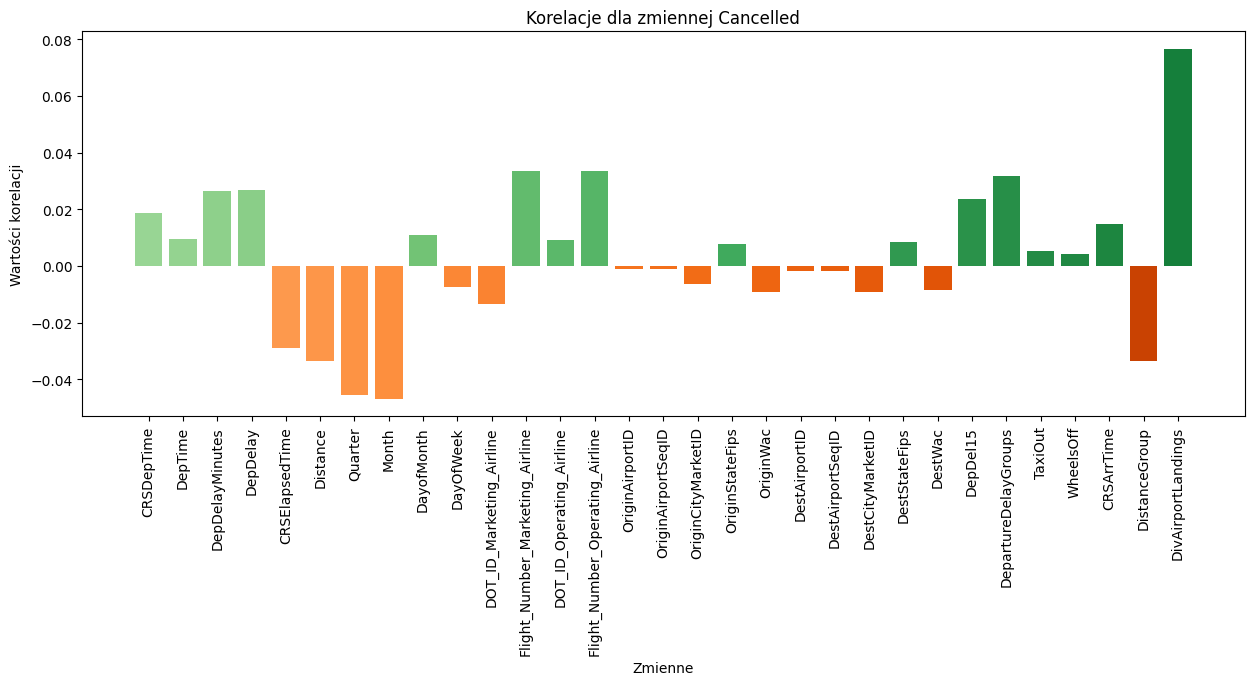

In [8]:
features = cancelled_correlatons['feature']
values = cancelled_correlatons['value']

plus_collors = plt.cm.Greens(np.linspace(0.4, 0.8, len(features)))
minus_collors = plt.cm.Oranges(np.linspace(0.4, 0.8, len(features)))

colors = [plus_collors[index] if value >= 0 else minus_collors[index] for index, value in zip(range(len(values)), values)]

plt.figure(figsize=(15, 5))
plt.bar(features, values, color = colors)
plt.xticks(rotation = 90)
plt.xlabel('Zmienne')
plt.ylabel('Wartości korelacji')
plt.title('Korelacje dla zmiennej Cancelled')
plt.show()

Korelacja dla zmiennej **ArrDelayMinutes**

In [9]:
delayed_correlations

,feature,value
0,CRSDepTime,0.080599
1,DepTime,0.112018
2,DepDelayMinutes,0.978948
3,DepDelay,0.975337
4,ArrTime,0.015558
5,ArrDelayMinutes,1.000000
6,AirTime,0.014610
7,CRSElapsedTime,0.009336
8,ActualElapsedTime,0.046823
9,Distance,0.002536


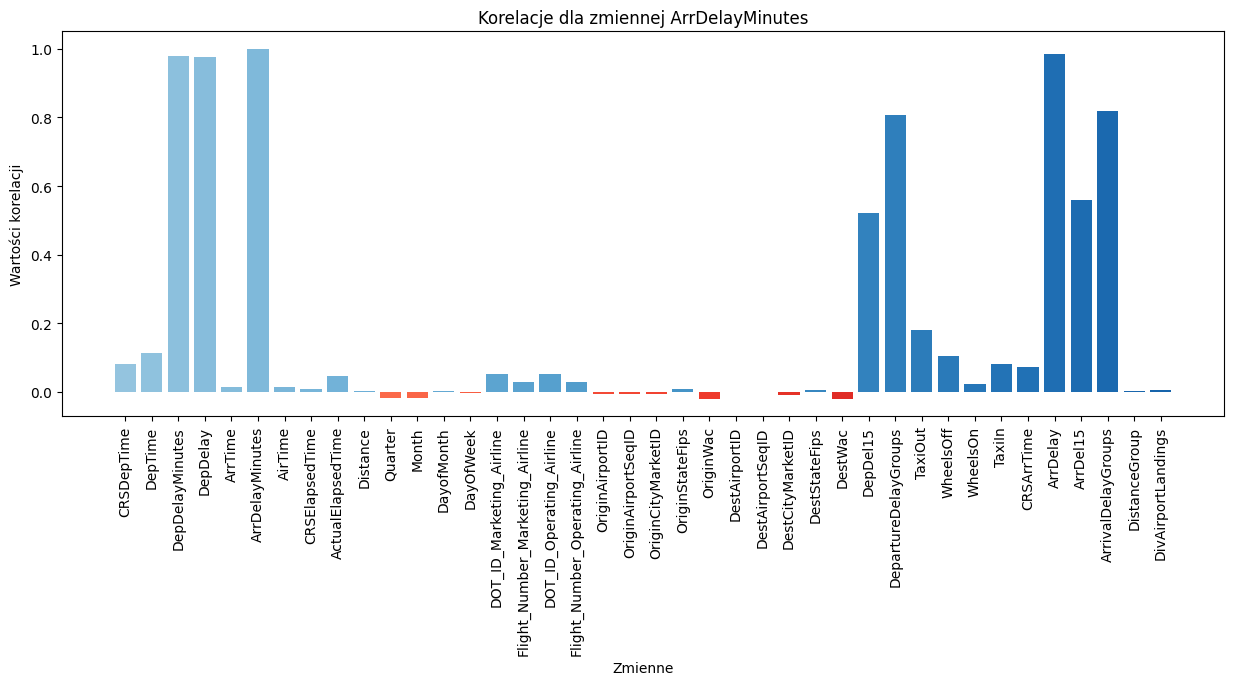

In [10]:
features = delayed_correlations['feature']
values = delayed_correlations['value']

plus_collors = plt.cm.Blues(np.linspace(0.4, 0.8, len(features)))
minus_collors = plt.cm.Reds(np.linspace(0.4, 0.8, len(features)))

colors = [plus_collors[index] if value >= 0 else minus_collors[index] for index, value in zip(range(len(values)), values)]

plt.figure(figsize=(15, 5))
plt.bar(features, values, color = colors)
plt.xticks(rotation = 90)
plt.xlabel('Zmienne')
plt.ylabel('Wartości korelacji')
plt.title('Korelacje dla zmiennej ArrDelayMinutes')
plt.show()

Z zebranych danych można wywnioskować, że zmienna **ArrDelayMinutes** ma silne korelacje z innymi cechami. <br/>
Zmienna **Cancelled** ma słabsze korelacje

In [11]:
df = df.dropna(subset=number_columns).reset_index(drop=True);
number_columns


['CRSDepTime',
 'DepTime',
 'DepDelayMinutes',
 'DepDelay',
 'ArrTime',
 'ArrDelayMinutes',
 'AirTime',
 'CRSElapsedTime',
 'ActualElapsedTime',
 'Distance',
 'Year',
 'Quarter',
 'Month',
 'DayofMonth',
 'DayOfWeek',
 'DOT_ID_Marketing_Airline',
 'Flight_Number_Marketing_Airline',
 'DOT_ID_Operating_Airline',
 'Flight_Number_Operating_Airline',
 'OriginAirportID',
 'OriginAirportSeqID',
 'OriginCityMarketID',
 'OriginStateFips',
 'OriginWac',
 'DestAirportID',
 'DestAirportSeqID',
 'DestCityMarketID',
 'DestStateFips',
 'DestWac',
 'DepDel15',
 'DepartureDelayGroups',
 'TaxiOut',
 'WheelsOff',
 'WheelsOn',
 'TaxiIn',
 'CRSArrTime',
 'ArrDelay',
 'ArrDel15',
 'ArrivalDelayGroups',
 'DistanceGroup',
 'DivAirportLandings']

Zostały ununięte wartości NaN

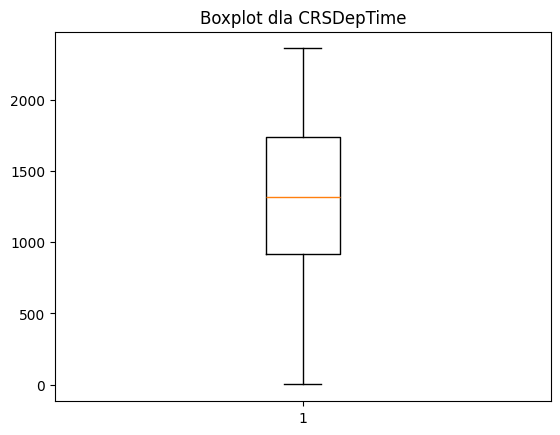

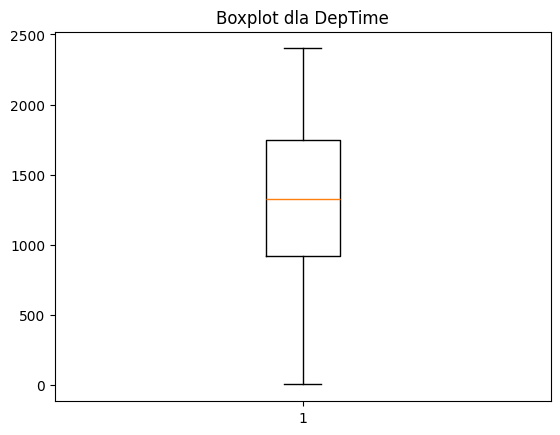

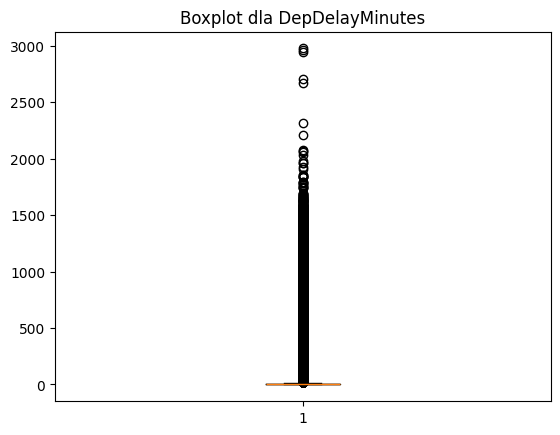

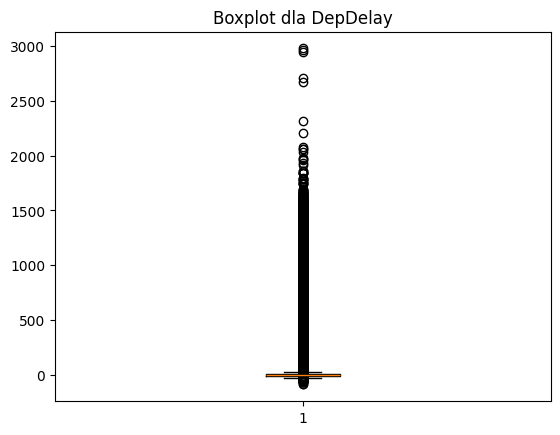

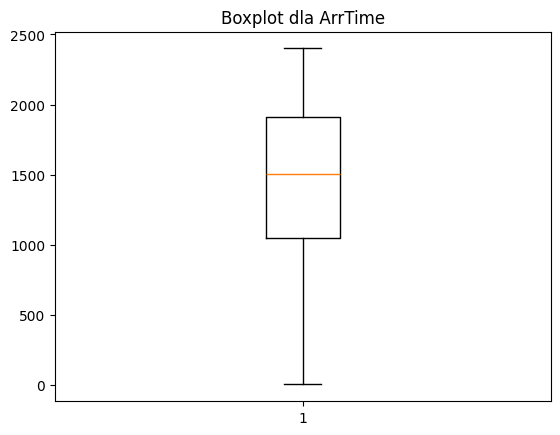

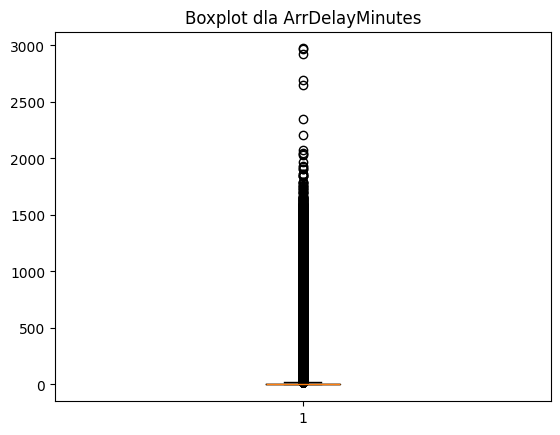

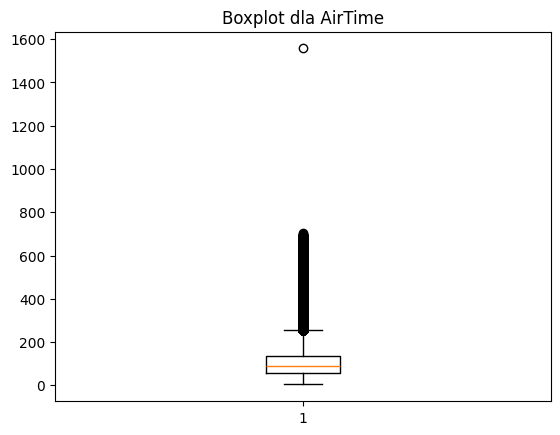

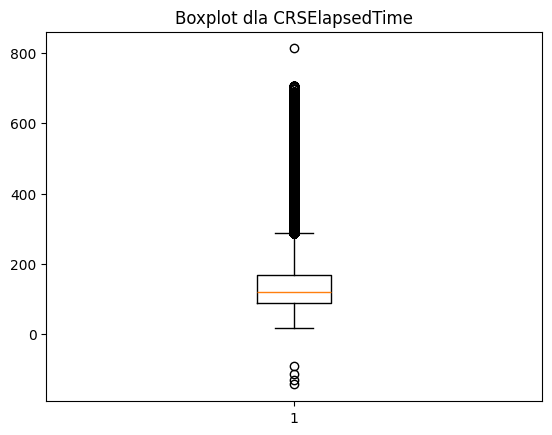

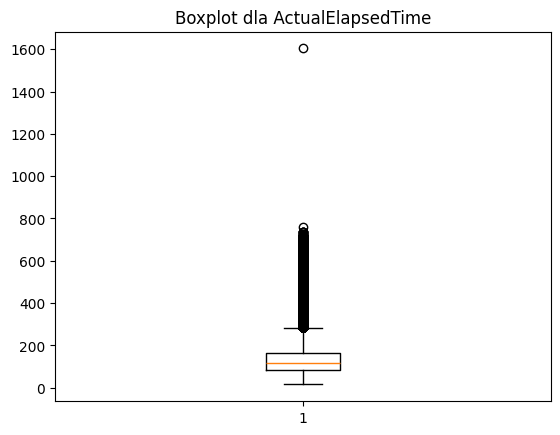

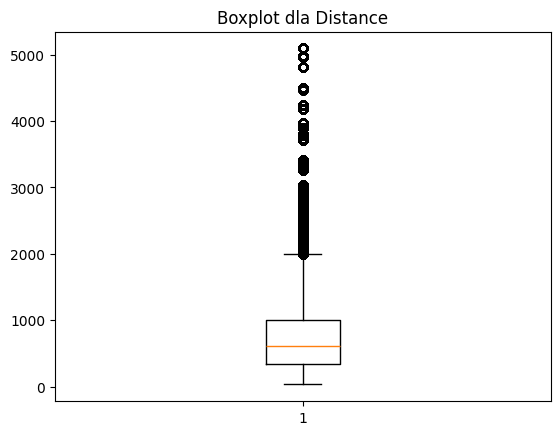

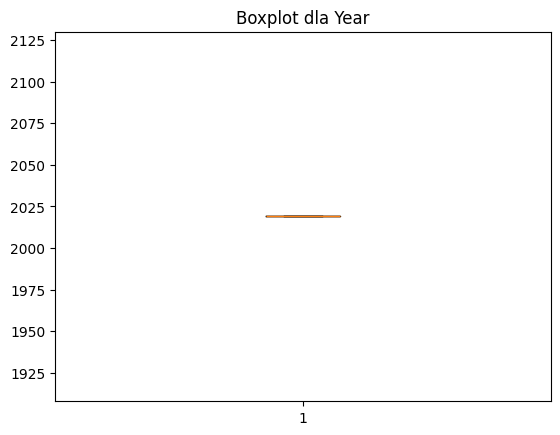

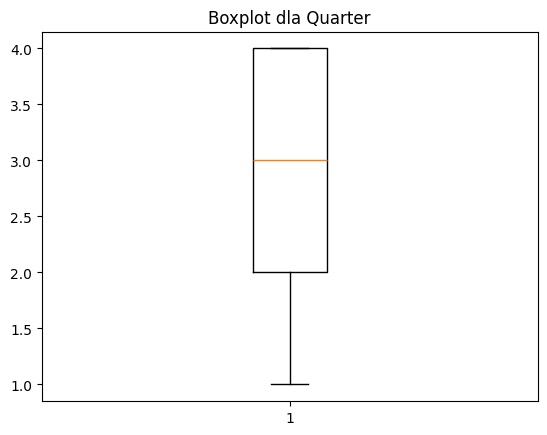

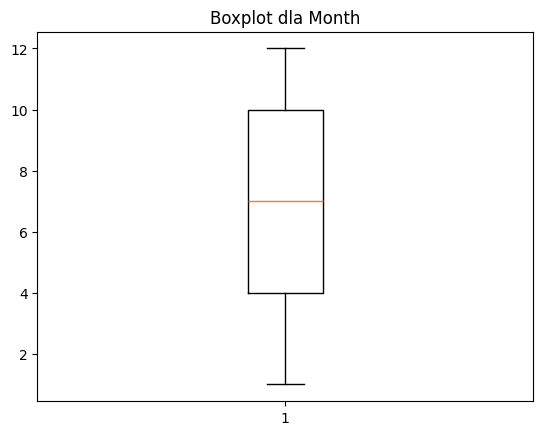

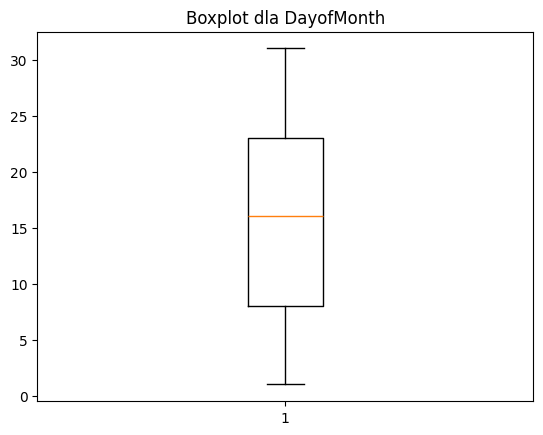

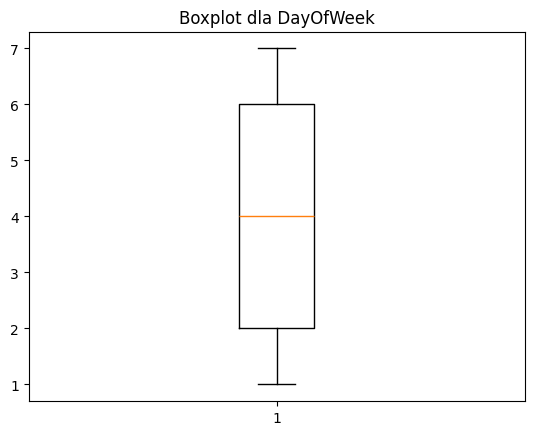

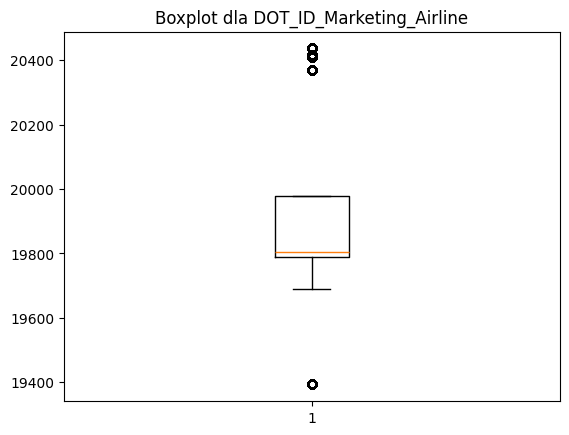

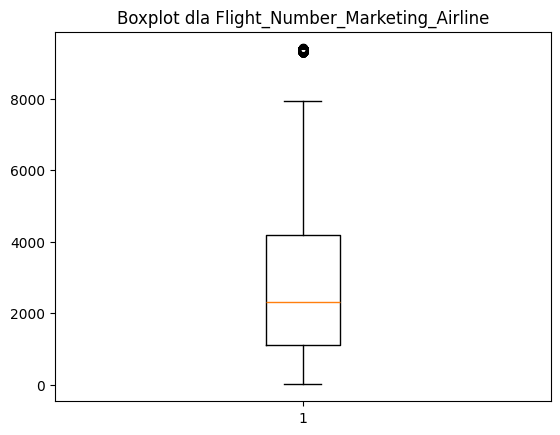

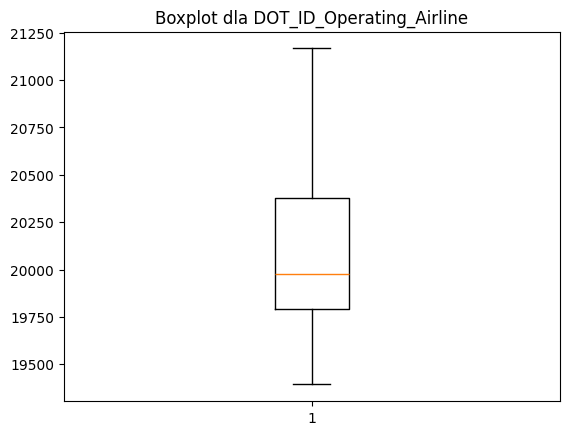

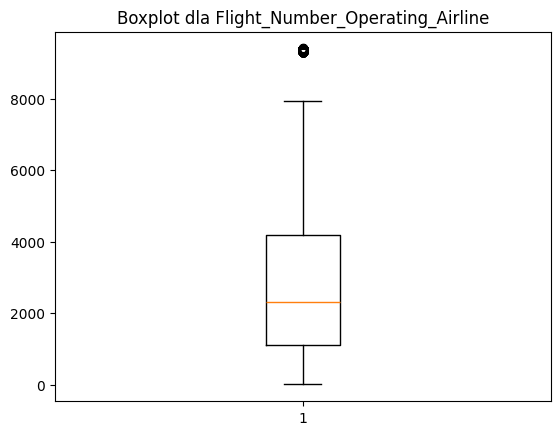

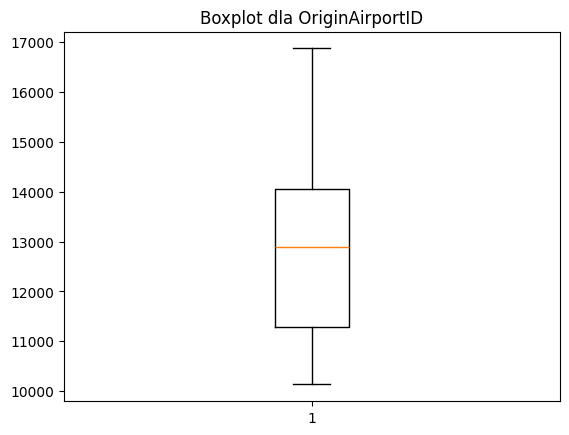

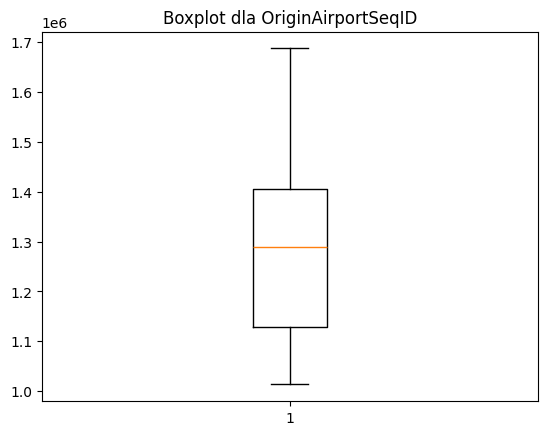

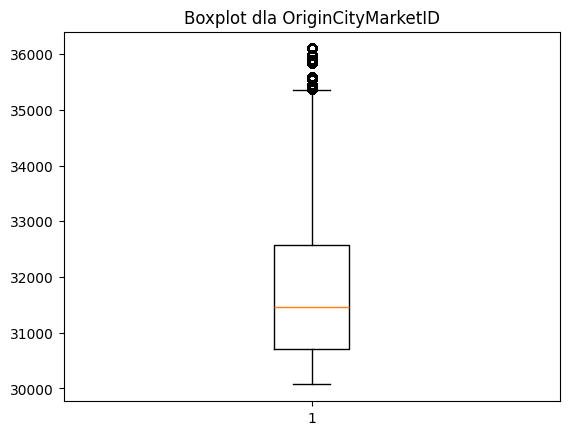

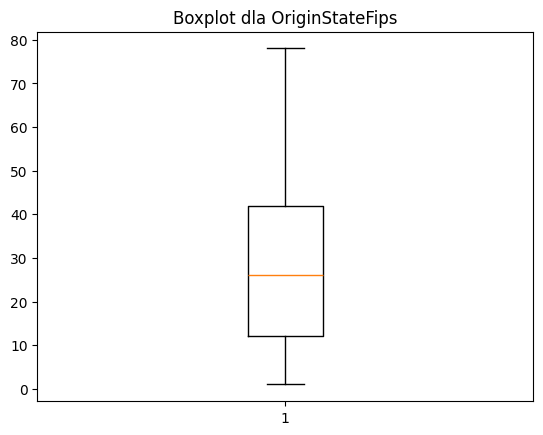

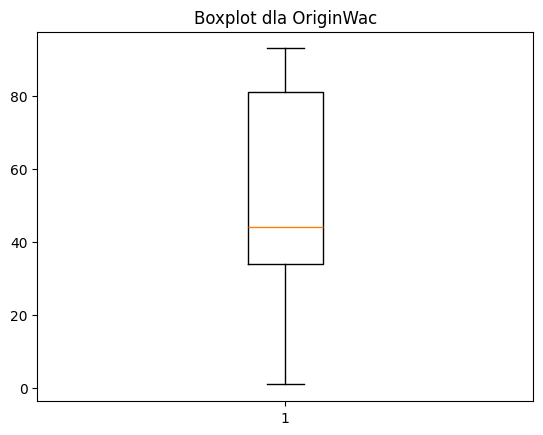

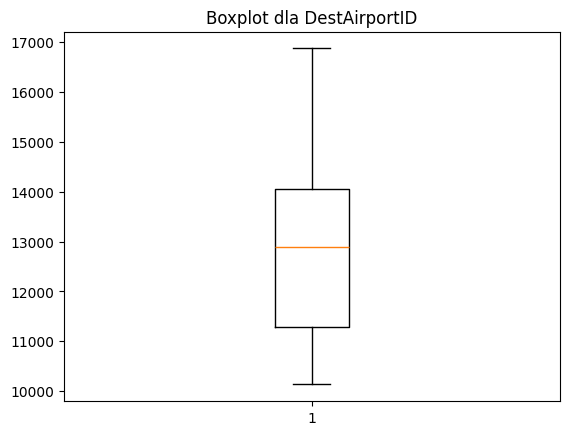

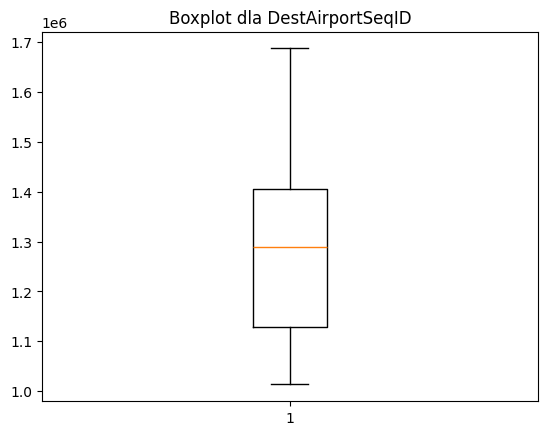

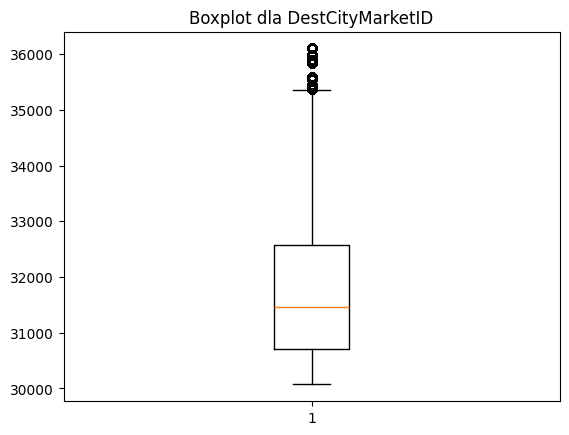

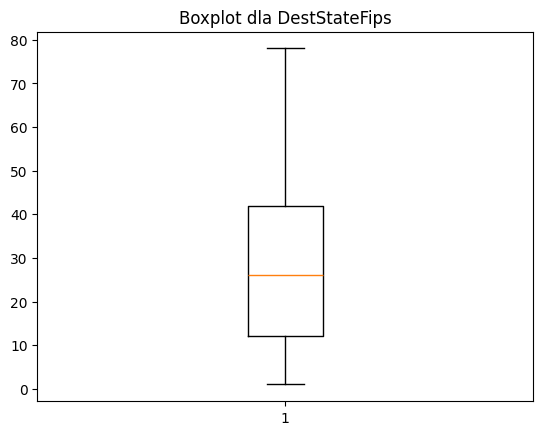

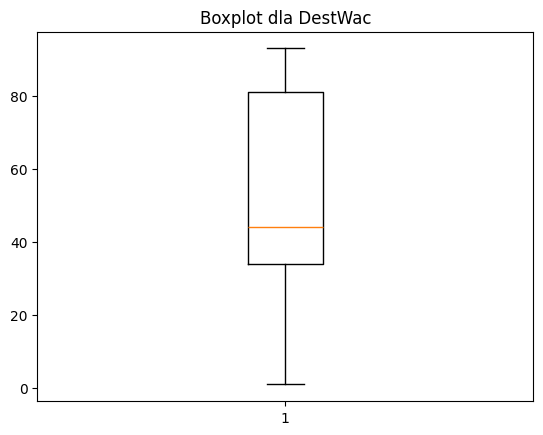

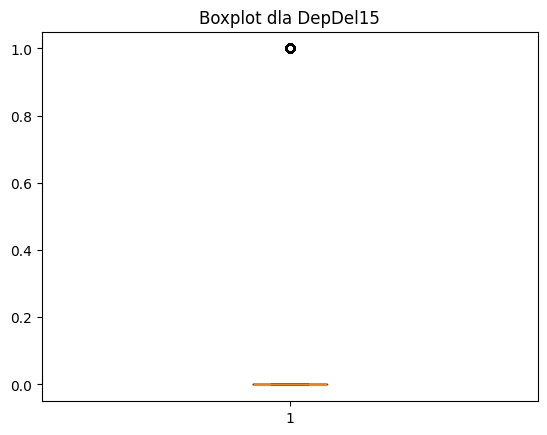

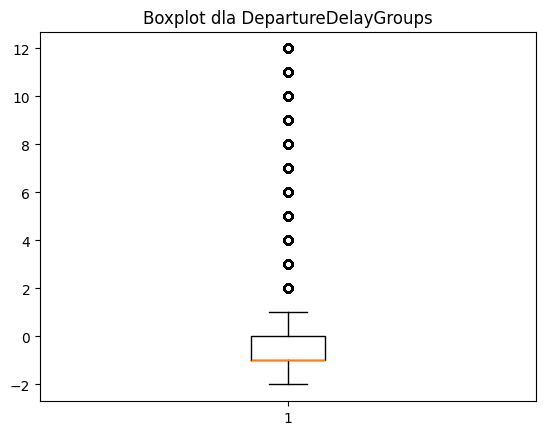

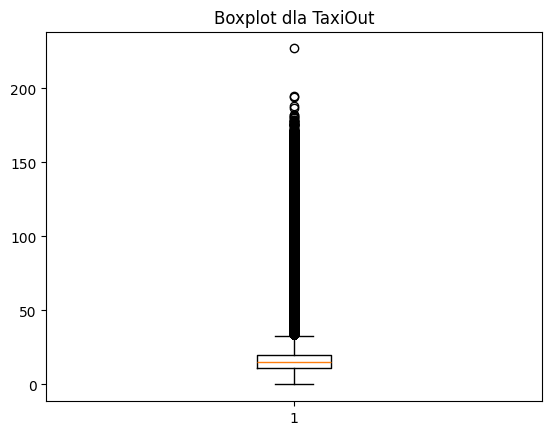

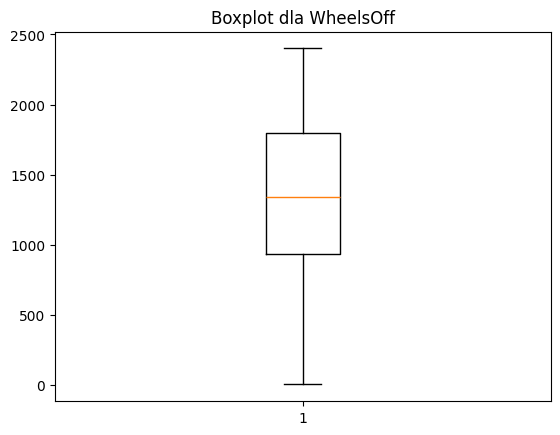

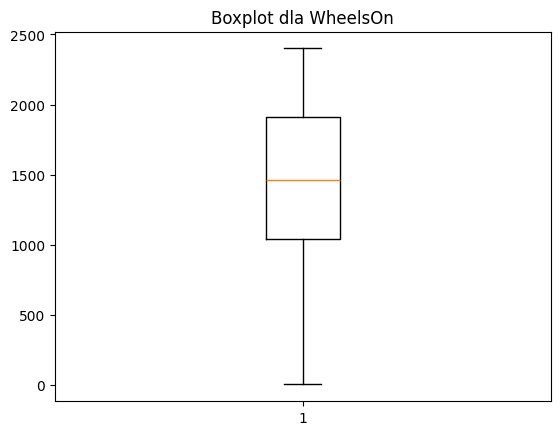

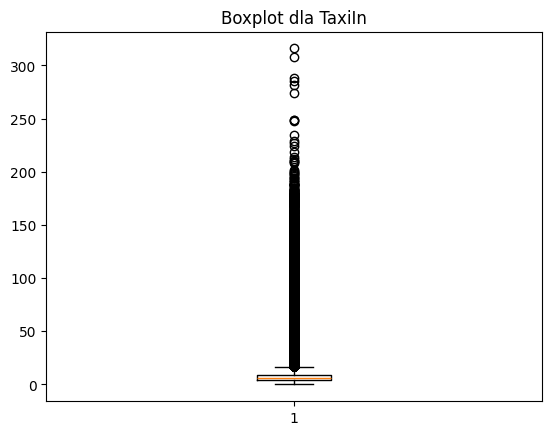

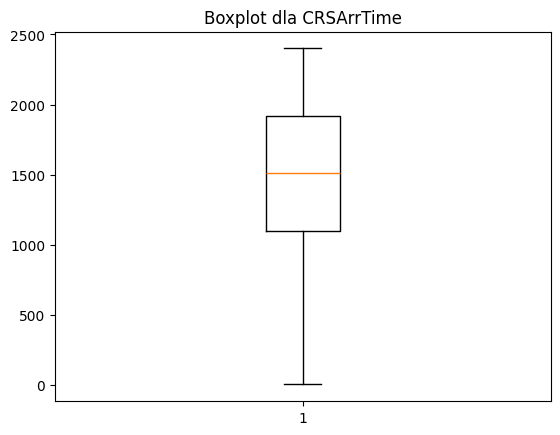

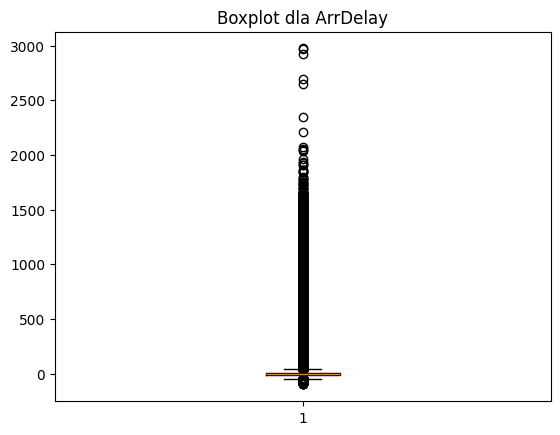

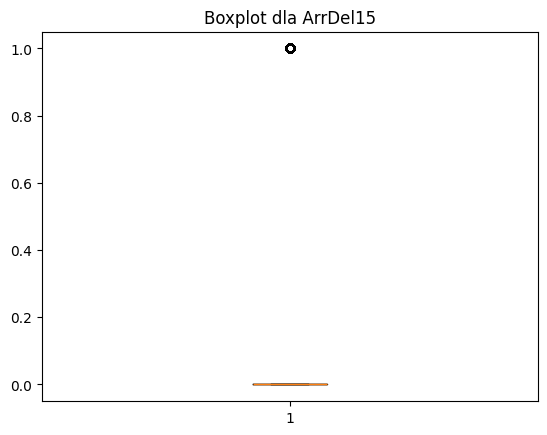

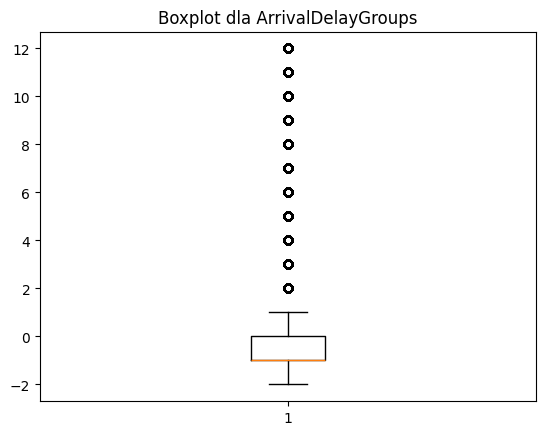

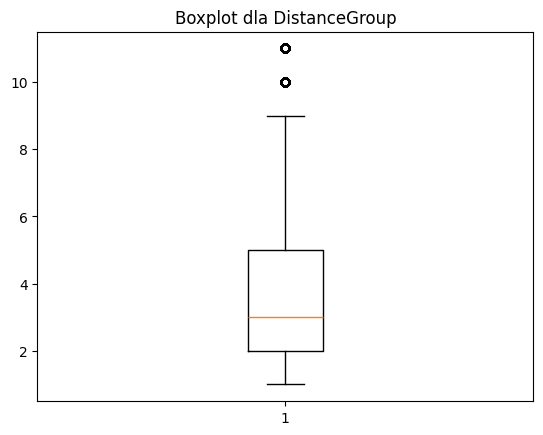

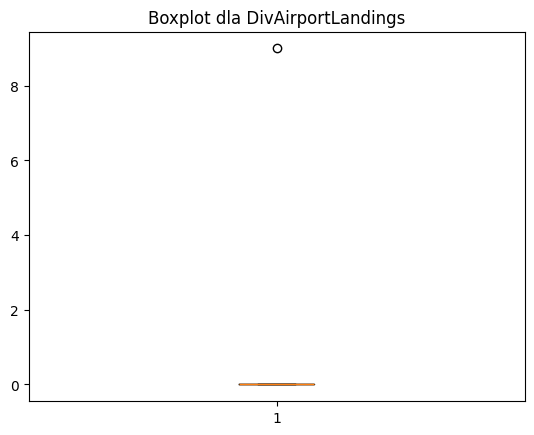

In [12]:
for value in number_columns:
    plt.title(f'Boxplot dla {value}')
    plt.boxplot(df[value])
    plt.show()

Powyższe wykresy pokazują statystyki dla cech

In [13]:
df = dd.read_csv('Combined_Flights_2019.csv').sample(frac=0.01, random_state=42).compute()
df = df.dropna(subset=number_columns).reset_index(drop=True)

plus_corr_canceled = cancelled_correlatons[cancelled_correlatons['value'] > 0]['feature'].to_numpy()
plus_corr_delayed = delayed_correlations[delayed_correlations['value'] > 0]['feature'].to_numpy()

plus_corr_canceled = da.from_array(plus_corr_canceled, chunks = 100,)
plus_corr_delayed = da.from_array(plus_corr_delayed, chunks = 100,)
nan_columns = da.from_array(np.array(nan_columns), chunks = 100,)

nan_values_in_df = np.array([value for value in list(nan_columns.compute()) if value in df.columns])

combined_1 = da.hstack((plus_corr_canceled, nan_values_in_df))
combined_2 = da.hstack((plus_corr_canceled, nan_values_in_df))

combined_1 = da.unique(combined_1).compute()
combined_2 = da.unique(combined_2).compute()

combined_1 = np.append(combined_1, 'Cancelled')
combined_2 = np.append(combined_2, 'ArrDelayMinutes')

df1 = df[combined_1]
df2 = df[combined_2]

df1 = dd.get_dummies(df1, columns=np.array(nan_values_in_df))
df2 = dd.get_dummies(df2, columns=np.array(nan_values_in_df))


y_1 = dd.from_pandas(df1['Cancelled'])
y_2 = dd.from_pandas(df2['ArrDelayMinutes'])

x_1 = dd.from_pandas(df1.drop('Cancelled', axis=1))
x_2 = dd.from_pandas(df2.drop('ArrDelayMinutes', axis=1))

Powyższe dane są gotowe do trenowania modeli ml. Na danych nienumerycznych zastosowano one hot, a z danych numerycznych zostały wybrane te z dodatnią korelacją.

In [ ]:
from sklearn.metrics import root_mean_squared_error


regressors = [
    BayesianRidge(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    HistGradientBoostingRegressor(),
    SVR(),
    KNeighborsRegressor(),
    MLPRegressor()
]

x_2_local = x_2.compute()
y_2_local = y_2.compute()

X_train, X_test, y_train, y_test = train_test_split(
    x_2_local, 
    y_2_local, 
    test_size=0.2, 
    random_state=42
)

rmse_values = []

for regressor in regressors:
    model = regressor
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)

    rmse_values.append(rmse)

rmse_df = pd.DataFrame({'regressor': regressors, 'rmse': rmse_values})
rmse_df

In [18]:
best_regressor = rmse_df['regressor'][rmse_df['rmse'] == rmse_df['rmse'].min()].iloc[0]
print(f"Najdokładniejszy regresor: {best_regressor} z dokładnością {rmse_df['rmse'].min()}")

Najdokładniejszy regresor: GradientBoostingRegressor() z dokładnością 7.095664599740141


Powyżej została wykonana analiza regresorów

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    x_2_local, 
    y_2_local, 
    test_size=0.2, 
    random_state=42
)

model = best_regressor

model.fit(X_train, y_train)

GradientBoostingRegressor()

Ostateczny model regresji

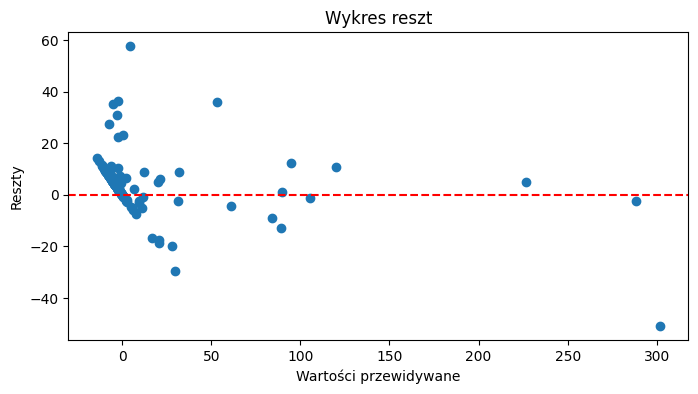

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 4))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Wartości przewidywane')
plt.ylabel('Reszty')
plt.title('Wykres reszt')
plt.show()

Wykres reszt pokazuje różnice między wartościami rzeczywistymi a przewidywanymi przez model, na osi pionowej względem wartości przewidywanych. Pomaga ocenić jakość dopasowania modelu oraz wykryć potencjalne problemy, jak np. brak liniowości czy heteroskedastyczność.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

x_2_pd = x_2.compute()
y_2_pd = y_2.compute()

model = BayesianRidge()
kf = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, x_2_pd, y_2_pd, scoring='neg_mean_squared_error', cv=kf)
mse_scores = -scores
rmse_scores = np.sqrt(mse_scores)


print("Wyniki walidacji krzyżowej:\n", rmse_scores)
print("Średni RMSE:", rmse_scores.mean())


Wyniki walidacji krzyżowej:
 [ 7.13813015  6.87404664  6.74715572  6.01012551  5.14887023  6.16631204
 10.01799598  6.59887579  5.00144644  7.70167667]
Średni RMSE: 6.740463518496467


Walidacja krzyżowa pokazuje jakość danych i modelu. Wyniki walidacji krzyżowej są zadowalające

In [ ]:
df = dd.read_csv('Combined_Flights_2019.csv').compute()
df = df.dropna(subset=number_columns).reset_index(drop=True)

print(df[df['Cancelled'] == True])

Empty DataFrame
Columns: [FlightDate, Airline, Origin, Dest, Cancelled, Diverted, CRSDepTime, DepTime, DepDelayMinutes, DepDelay, ArrTime, ArrDelayMinutes, AirTime, CRSElapsedTime, ActualElapsedTime, Distance, Year, Quarter, Month, DayofMonth, DayOfWeek, Marketing_Airline_Network, Operated_or_Branded_Code_Share_Partners, DOT_ID_Marketing_Airline, IATA_Code_Marketing_Airline, Flight_Number_Marketing_Airline, Operating_Airline, DOT_ID_Operating_Airline, IATA_Code_Operating_Airline, Tail_Number, Flight_Number_Operating_Airline, OriginAirportID, OriginAirportSeqID, OriginCityMarketID, OriginCityName, OriginState, OriginStateFips, OriginStateName, OriginWac, DestAirportID, DestAirportSeqID, DestCityMarketID, DestCityName, DestState, DestStateFips, DestStateName, DestWac, DepDel15, DepartureDelayGroups, DepTimeBlk, TaxiOut, WheelsOff, WheelsOn, TaxiIn, CRSArrTime, ArrDelay, ArrDel15, ArrivalDelayGroups, ArrTimeBlk, DistanceGroup, DivAirportLandings]
Index: []

[0 rows x 61 columns]


Pierwotnym celem było również dokonanie predykcji zmiennej **Cancelled**. Analiza danych pokazuje, że jest to niemożliwe przez brak wartości innych niż False dla tej cechy 

In [24]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Model regresji został zapisany do pliku pickle